In [1]:

#import all libraries we used

import pandas as pd
from bs4 import BeautifulSoup
import requests
import html5lib
import os
import re

In [2]:

#create our DataFrame

def createDf():
    data = {'round': [], 'season': [], 'date':[], 'hour':[], 'home team': [], 'guest team': [], 'score': [],'winners': []}
    df = pd.DataFrame(data)
    return df

In [3]:

#Create a string of two seasons

def season(firstY,secondY):
    years = firstY+"-"+secondY
    return years

In [4]:

#Create BeautifulSoup object

def load_soup_object(years,rounds):
    if years == "2016-2017":
        url = "https://www.worldfootball.net/schedule/esp-primera-division-"+years+"-spieltag_2/"+rounds
    else:
        url = "https://www.worldfootball.net/schedule/esp-primera-division-"+years+"-spieltag/"+rounds
    r = requests.get(url)
    soup = BeautifulSoup(r.text,'html.parser')
    return soup

In [5]:

#Insert our BeautifulSoup object to our Dataframe

def insertSoupToDataFrame(soup,df,rounds,years):
    
    date=list()
    hour=list()
    homeTeam=list()
    guestTeam=list()
    score=list()
    
    table = soup.find('table',attrs={"class":"standard_tabelle"})
    
    for row in table("tr"):
        cells = row("td")
        if(len(cells)<6):
            continue
        if cells[0].get_text() != "":
            temp = cells[0].get_text()
            date.append(cells[0].get_text())
        else:
            date.append(temp)
        hour.append(cells[1].get_text())
        homeTeam.append(cells[2].get_text().strip())
        guestTeam.append(cells[4].get_text().strip())
        score.append(cells[5].get_text().strip())
        
        
    data = {'round': rounds, 'season': years, 'date':date, 'hour':hour, 'home team': homeTeam, 'guest team': guestTeam, 'score': score}
    df = pd.DataFrame(data)
    return df
    

In [6]:

#Our main function to get our data using the last functions of creatring BeautifulSoup and dataframe

def getData():
    yearList = ["2000", "2001", "2002","2003", "2004", "2005","2006", "2007", "2008","2009",
                "2010", "2011","2012", "2013", "2014","2015", "2016", "2017","2018", "2019", "2020","2021", "2022"]

    roundsList = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
                  "11", "12","13", "14", "15", "16", "17", "18", "19", "20",
                  "21", "22", "23", "24", "25", "26", "27", "28", "29", "30",
                  "31", "32", "33", "34", "35", "36", "37", "38"]

    df = createDf()
    tempYear = 0;
    tempRounds = 0;
    for year in yearList:
        if yearList[tempYear] == "2022" :
            break
        years = season(yearList[tempYear],yearList[tempYear+1])
        for rounds in roundsList:
            soup = load_soup_object(years,rounds)
            df1 = insertSoupToDataFrame(soup,df,rounds,years)
            df = df.append(df1, ignore_index=True)
            tempRounds = tempRounds+1
        tempYear=tempYear+1
    
    return df

In [7]:

#Check the score and fill winners column 

def getWinners(df):
    df1 = df.copy()
    temp = df.score
    winners = list()
    for i in temp:
        if i[0] < i[2]:
            winners.append("Away")
        elif i[0] > i[2]:
            winners.append("Home")
        else:
            winners.append("Draw")
    df1.winners = winners
    return df1

In [8]:

#Edit the score 

def editScore(df):
    df1 = df.copy()
    temp = df.score
    scoreEdit = list()
    for i in temp:
            i = i[0: 3]
            scoreEdit.append(i)
    df1.score = scoreEdit
    return df1

In [9]:

#update empty hours with the value 0

def updateHours(df):
    df1 = df.copy()
    temp = df.hour
    hours = list()
    for i in temp:
        if i=="NaN" or i == "":
            hours.append("0")
        else:
            hours.append(i)
    df1.hour = hours
    return df1

In [ ]:
df = getData()
df1 = getWinners(df)
df2 = updateHours(df1)
df3 = editScore(df2)
df3.to_csv('data.csv')
df3

C:\Users\edenm\AppData\Local\Temp\ipykernel_28356\3562828952.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df1, ignore_index=True)


In [2]:
df = pd.read_csv('data.csv')
df1 = df.drop(['Unnamed: 0'], axis=1)
df2 = df1.dropna(axis=0)
df2

,round,season,date,hour,home team,guest team,score,winners
0,1,2000-2001,09/09/2000,0,Real Zaragoza,Espanyol Barcelona,1:2,Away
1,1,2000-2001,09/09/2000,0,Real Madrid,Valencia CF,2:1,Home
2,1,2000-2001,09/09/2000,0,FC Barcelona,Málaga CF,2:1,Home
3,1,2000-2001,09/09/2000,0,Deportivo La Coruña,Athletic Bilbao,2:0,Home
4,1,2000-2001,09/09/2000,0,Real Sociedad,Racing Santander,2:2,Draw
...,...,...,...,...,...,...,...,...
8355,38,2021-2022,22/05/2022,19:00,CD Alavés,Cádiz CF,0:1,Away
8356,38,2021-2022,22/05/2022,19:00,Granada CF,Espanyol Barcelona,0:0,Draw
8357,38,2021-2022,22/05/2022,21:00,FC Barcelona,Villarreal CF,0:2,Away
8358,38,2021-2022,22/05/2022,21:00,Sevilla FC,Athletic Bilbao,1:0,Home


In [3]:

# Filter DataFrame to have only games participated by a certine team (home & away)

def OneTeamDataFrameFilter(df, team):
    return df.loc[(df['home team'] == team) | (df['guest team'] == team)]

In [4]:

#Filter DataFrame to have only games participated by certine 2 teams (home & away)

def TwoTeamsDataFarmeFilter(df, team1, team2):
    return pd.concat([df.loc[(df['home team'] == team1) & (df['guest team'] == team2)],df.loc[(df['home team'] == team2) & (df['guest team'] == team1)]])

In [5]:

# charts maker

def one_dim_plot(sr, plot_type,plot_title):
    return sr.plot(kind=plot_type, title=plot_title)

In [6]:

# two teams win & loss ratio - pie chart

def TwoTeamsWinsPieChart(df, team1, team2):
    df_copy = TwoTeamsDataFarmeFilter(df, team1, team2)
    
    team1_wins = len(df_copy[(df_copy['home team'] == team1) & (df_copy['winners']=='Home')].index) + len(df_copy[(df_copy['guest team'] == team1) & (df_copy['winners']=='Away')].index)
    draws= 0
    for winner in df_copy.winners:
        if winner == 'Draw':
            draws = draws+1
    team2_wins= len(df_copy[(df_copy['home team'] == team2) & (df_copy['winners']=='Home')].index) + len(df_copy[(df_copy['guest team'] == team2) & (df_copy['winners']=='Away')].index)
    

    
    sr_data = pd.Series([team1_wins,draws,team2_wins], index=[team1, 'Draw', team2])
    one_dim_plot(sr_data, 'pie', f"{team1} & {team2} Matches")

In [7]:

# one team win & loss all time ratio - pie chart

def OneTeamWinsPieChart(df, team):
    df_copy =OneTeamDataFrameFilter(df, team)
    wins=len(df_copy[(df_copy['home team'] == team) & (df_copy['winners']=='Home')].index) + len(df_copy[(df_copy['guest team'] == team) & (df_copy['winners']=='Away')].index)
    draws=0
    for winner in df_copy.winners:
        if winner == 'Draw':
            draws = draws+1
    losses= len(df_copy.index)-wins-draws
    
    sr_data = pd.Series([wins,draws,losses], index=['Wins', 'Draws', 'Losses'])
    one_dim_plot(sr_data, 'pie', f"{team} Wins & Losses")

In [8]:

# two teams goals all time ratio - pie chart

def TwoTeamsGoalsPieChart(df, team1, team2):
    df_copy = TwoTeamsDataFarmeFilter(df, team1, team2)
    team1_score = 0
    team2_score = 0
    for index in df_copy.index:
        
        home_score = int(df_copy['score'][index][0]) 
        away_score = int(df_copy['score'][index][2] )
        
        if(df_copy['home team'][index] == team1):
            team1_score += home_score
            team2_score += away_score
        else:
            team1_score += away_score
            team2_score += home_score
            
    sr_data = pd.Series([team1_score,team2_score], index=[team1, team2])
    one_dim_plot(sr_data, 'pie', f"{team1} & {team2} Matches Total Goals")

In [9]:

# one team goals all time ratio - pie chart

def OneTeamGoalsPieChart(df, team):
    df_copy = OneTeamDataFrameFilter(df, team)
    scored = 0
    scored_to = 0
    for index in df_copy.index:
     
        home_score = int(df_copy['score'][index][0]) 
        away_score = int(df_copy['score'][index][2] )
        
        if(df_copy['home team'][index] == team):
            scored += home_score
            scored_to += away_score
        else:
            scored += away_score
            scored_to += home_score
            
    sr_data = pd.Series([scored,scored_to], index=['Scored', 'Scored To'])
    one_dim_plot(sr_data, 'pie', f"{team} Matches Total Goals")

In [22]:

#

def HomeAwayWinLossRatiosBarChart(df, team):
    df_copy = OneTeamDataFrameFilter(df,team)
    
    home_resault_df = pd.DataFrame({'Wins':[0,0], 'Losses':[0,0]}, index = ['Home','Away'])
    away_resault_df = pd.DataFrame({'Wins':[0], 'Losses':[0]}, index = ['Away'])
    
    for index in df_copy.index:
        if(df_copy['home team'][index] == team):
            if(df_copy['winners'][index] == 'Home'):
                home_resault_df['Wins'][0]+=1
            else:
                home_resault_df['Losses'][0]+=1
        else:
            if(df_copy['winners'][index] == 'Home'):
                home_resault_df['Losses'][1]+=1
            else:
                home_resault_df['Wins'][1]+=1
                
    ax = home_resault_df.plot.bar(rot=0)  
    print(home_resault_df)
    print(away_resault_df)
        
    
    

      Wins  Losses
Home   128     176
Away   142     162
      Wins  Losses
Away     0       0


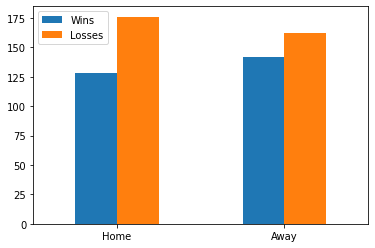

In [24]:
HomeAwayWinLossRatiosBarChart(df2, 'Málaga CF')

In [ ]:
HomeAwayWinLossRatiosBarChart(df2, 'Atlético Madrid')

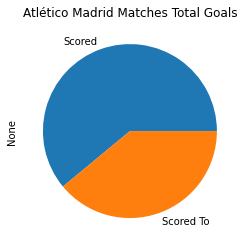

In [113]:
OneTeamGoalsPieChart(df2,'Atlético Madrid')

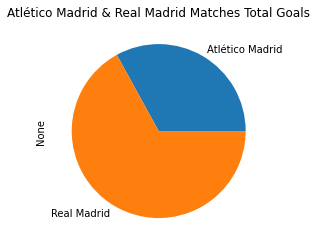

In [106]:
TwoTeamsGoalsPieChart(df2,'Atlético Madrid', 'Real Madrid')

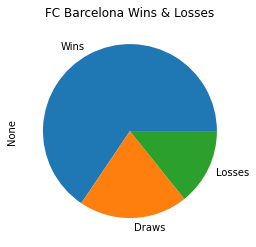

In [69]:
OneTeamWinsPieChart(df2, 'FC Barcelona')

13
None


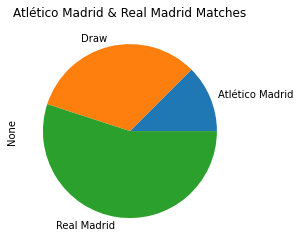

In [66]:
print(TwoTeamsWinsPieChart(df2, 'Atlético Madrid', 'Real Madrid'))

3
None


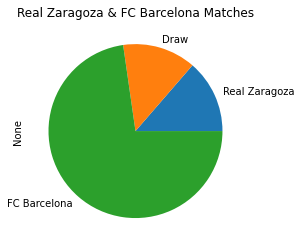

In [67]:
print(TwoTeamsWinsPieChart(df2, 'Real Zaragoza', 'FC Barcelona'))